# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib
import json
import tensorflow as tf



# Load Saved Model

In [2]:
# Load the models and scalers
xgb_model = joblib.load('xgboost_model.joblib')
lstm_model = tf.keras.models.load_model('lstm_model.keras')
feature_scaler = joblib.load('feature_scaler.joblib')
target_scaler = joblib.load('target_scaler.joblib')

# Load sequence length from config
with open('config.json', 'r') as f:
    config = json.load(f)
    sequence_length = config['sequence_length']

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Data Preprocessing

In [ ]:
# Load the data
data = pd.read_csv('../datasets/nflx.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low  Close   Volume
0  2005-01-03  12.48  12.60  11.52  11.92  1619200
1  2005-01-04  11.92  11.95  11.25  11.66  2478900
2  2005-01-05  11.74  11.74  11.09  11.20  1818900
3  2005-01-06  11.20  11.37  11.01  11.05  1181900
4  2005-01-07  11.11  11.55  11.00  11.12  1070100


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2005-03-15,9.47,9.62,9.12,9.20,1505100,9.606,10.068,10.3665,10.9282,9.589113,9.913983,10.289715,10.825425,34.482759
50,2005-03-16,9.11,9.32,9.10,9.17,1037200,9.438,9.917,10.2625,10.8732,9.449408,9.778714,10.183075,10.760506,29.568106
51,2005-03-17,9.22,9.24,9.15,9.20,650700,9.300,9.781,10.1750,10.8240,9.366272,9.673493,10.089449,10.699310,13.469388
52,2005-03-18,9.25,9.25,9.15,9.20,997600,9.254,9.631,10.1100,10.7840,9.310848,9.587403,10.004740,10.640513,15.277778
53,2005-03-21,9.25,9.50,9.16,9.31,884900,9.216,9.503,10.0420,10.7492,9.310565,9.536966,9.938574,10.588336,16.055046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2007-03-05,22.01,22.16,21.05,21.06,2443000,22.162,22.812,22.8400,23.6432,22.106463,22.480152,22.780457,23.662933,33.492823
545,2007-03-06,21.25,21.91,20.91,21.44,2019000,22.030,22.605,22.7820,23.5308,21.884308,22.291033,22.652794,23.575759,38.629283
546,2007-03-07,21.50,21.60,21.07,21.18,1228500,21.760,22.384,22.7250,23.4072,21.649539,22.089027,22.512528,23.481808,38.871473
547,2007-03-08,21.21,21.63,21.21,21.24,902900,21.442,22.133,22.6420,23.2962,21.513026,21.934659,22.391335,23.393894,40.063091


In [ ]:
from xgboost import XGBRegressor


feature_columns = [
    'Close',          
    'Low',            
    'High',           
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'          
]

X = data[feature_columns].values
y = data['Close'].values

# Scale features using the loaded scaler
X_scaled = feature_scaler.transform(X)

# Get XGBoost predictions
xgb_predictions = xgb_model.predict(X_scaled)

# Combine features with XGBoost predictions
combined_features = np.column_stack((X_scaled, xgb_predictions))

# Create sequences for LSTM
X_sequences = []
y_actual = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_actual.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_actual = np.array(y_actual)

In [5]:
# Make predictions
lstm_predictions = lstm_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


# Performance Evaluation

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 2431.59
RMSE:49.31 
MAE: 42.21 
R2 Score: 0.7173 


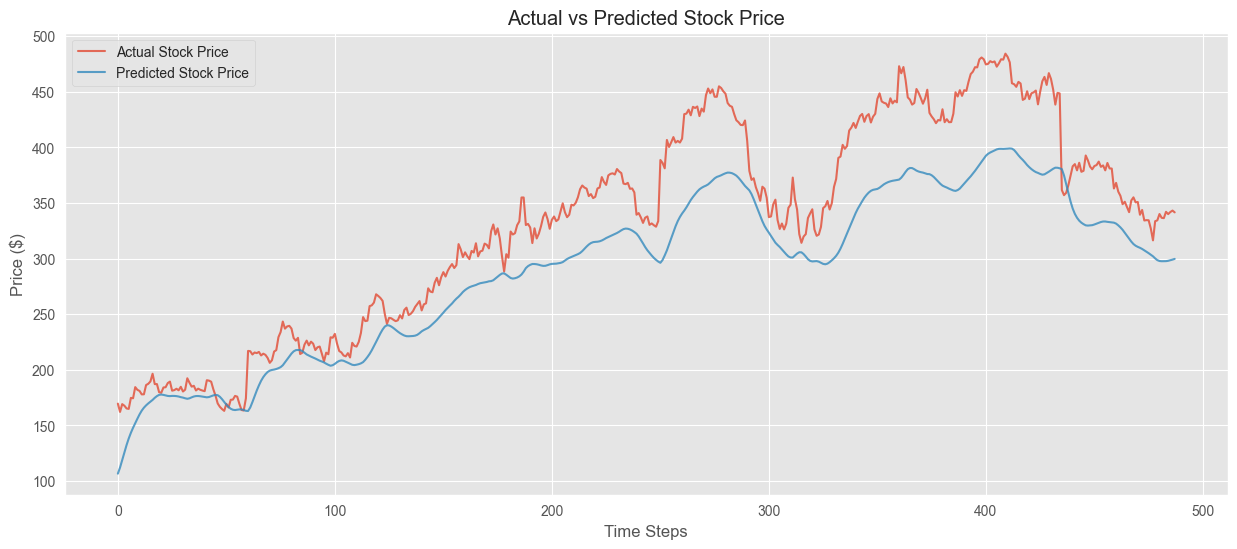

In [ ]:
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [9]:
# Save metrics to CSV
save_metrics(val_actual, val_predictions, 'XGBoost-LSTM', 'NFLX')


Metrics for XGBoost-LSTM on NFLX:
Mean Squared Error (MSE): 2431.5894
Root Mean Squared Error (RMSE): 49.3111
Mean Absolute Error (MAE): 42.2058
Mean Absolute Percentage Error (MAPE): 32.6777%
R² Score: 0.7173
